# Predicting the Attendance for the 2017 Miami Marathon

<div style="text-align: right"> Amen Memmi</div>
<div style="text-align: right"> amen.memmi@mail.mcgill.ca</div>
<div style="text-align: right">  ID: 260755070</div>

### This notebook is my participation in the group work for the first mini project from COMP-598 course. It aims at predicting the attendance for the 2017 Miami Marathon and it consists of data preprocessing, features engineering, balancing training classes and training naive Bayes classifier to finally generate the prediction file for the attendance. Details are below. 

The provided dataset includes participants in the Miami marathon and their performances, for the last 15 years. It contains over 38,000 entries.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import preprocessing

from sklearn.metrics import classification_report
from matplotlib import pyplot as plt
%matplotlib inline
from imblearn.combine import SMOTETomek #install from: conda install -c glemaitre imbalanced-learn
from collections import Counter



## Data preprocessing

In [2]:
data_df = pd.read_csv('Project1_data.csv')

In [3]:
data_df.tail(3)

,Id,Name,Age Category,Sex,Rank,Time,Pace,Year
38801,30415,regine wolf,45,F,511,3:44:54,08:35,2015
38802,30416,dimitri boutsikakis,35,M,640,3:51:36,08:50,2015
38803,30417,rodrigo pincheira,40,M,10,2:50:26,06:30,2015


Convert sex to numerical category:

In [4]:
data_df.Sex = pd.Categorical(data_df.Sex) # convert to Categorical
data_df.Sex = data_df.Sex.cat.codes       # map to category code:  Male:1,  Female:0

Convert time to seconds:

In [5]:
data_df.Time = pd.to_timedelta(data_df.Time,'s').dt.total_seconds().astype(int)

We drop Pace column since it give the same information as time, knowing that it's teh same distance:

In [6]:
data_df = data_df.drop(columns=['Pace'])

In [7]:
data_df.tail(3)

,Id,Name,Age Category,Sex,Rank,Time,Year
38801,30415,regine wolf,45,0,511,13494,2015
38802,30416,dimitri boutsikakis,35,1,640,13896,2015
38803,30417,rodrigo pincheira,40,1,10,10226,2015


In [8]:
data_df.Year.unique()

array([2016, 2015, 2014, 2010, 2008, 2009, 2007, 2011, 2006, 2012, 2013,
       2005, 2004, 2003], dtype=int64)

In [9]:
for y in range(2003,2017):
    m = data_df[data_df.Year == y].Time.mean()
    print(f'Average time for the year {y} is {m} ')

Average time for the year 2003 is 15480.990378006873 
Average time for the year 2004 is 16114.934463276837 
Average time for the year 2005 is 15955.415105053946 
Average time for the year 2006 is 16645.943564758425 
Average time for the year 2007 is 17014.228222309815 
Average time for the year 2008 is 16084.394986707179 
Average time for the year 2009 is 16141.63616636528 
Average time for the year 2010 is 16603.382291666665 
Average time for the year 2011 is 16032.712468193384 
Average time for the year 2012 is 16552.052658486708 
Average time for the year 2013 is 6687.648069804336 
Average time for the year 2014 is 17030.870375600112 
Average time for the year 2015 is 16248.480377906977 
Average time for the year 2016 is 16375.103116710876 


We noticed that Time data for 2013 is much lower than other years. After investigating the source (Athlinks.com), became apparent that the half marathon results were mistakenly included in the provided dataset. To rectify this, a scraper was written to pull the correct full marathon results and replace them.

In [10]:
data_df_2013 = pd.read_csv('full_marathon_data_2013.csv')
data_df_2013.sample(2)

,Id,Name,Age Category,Sex,Rank,Time,Pace,Year
632,30832,samuel rocke,26,M,635,3:52:11,NaN,2013
427,26478,tim odonohue,49,M,430,3:41:36,NaN,2013


In [11]:
data_df[data_df.Year!=2013].shape[0]

35022

In [12]:
# we apply the same changes
data_df_2013.Sex = pd.Categorical(data_df_2013.Sex) # convert to Categorical
data_df_2013.Sex = data_df_2013.Sex.cat.codes       # map to category code:  Male:1,  Female:0
data_df_2013.Time = pd.to_timedelta(data_df_2013.Time,'s').dt.total_seconds().astype(int)
data_df_2013 = data_df_2013.drop(columns=['Pace'])
data_df_2013.sample(2)

,Id,Name,Age Category,Sex,Rank,Time,Year
2503,32066,sky strickland,37,0,2409,17662,2013
471,30720,nelson sayegh,47,1,474,13444,2013


We drop the wrong old data and replace it with new acquired:

In [13]:
data_df = data_df[data_df.Year!=2013].append(data_df_2013,ignore_index=True)


We notice also that for some years the actual age is given while for other the age category is the one provided, we unify this to age category by 5 years chunks:

In [14]:
data_df['Age Category'] = data_df['Age Category'] //5  * 5

Let's check the biggest participation frequency 

In [15]:
data_df.Id.value_counts().head()

3327    301
2169     14
2034     14
635      14
1643     14
Name: Id, dtype: int64

There is some regular participants that were present each year since 2003, but there is an anomalie with id 3327 having participated 301 time in 14 years! Let's check it out:

In [16]:
data_df[data_df.Id==3327].head()

,Id,Name,Age Category,Sex,Rank,Time,Year
5276,3327,private,20,0,1682,16626,2014
5277,3327,private,45,0,2143,17668,2014
5278,3327,private,45,1,374,13425,2010
5279,3327,private,25,0,1010,15151,2014
5280,3327,private,50,0,2041,16452,2012


It seems like there are some people that prefered to keep their identity and all of them where labeled as 'private', we need to drop those:

In [17]:
data_df = data_df[data_df.Id!=3327].reset_index(drop=True)
data_df.sample(3)

,Id,Name,Age Category,Sex,Rank,Time,Year
24665,18104,andrew henshaw,25,1,5,8797,2011
16130,11144,alban brideau,55,1,486,14050,2007
8750,5474,mayer trobman,60,1,409,13888,2004


## Feature engineering:

In [18]:
data_df['run_count'] =  np.zeros(len(data_df))
data_df['years_since_run'] =  np.zeros(len(data_df))

In [19]:
sorted_df = data_df.sort_values(by=['Id','Year'])


In [20]:
sorted_df['run_count'] = sorted_df.groupby("Id").cumcount()
sorted_df['years_since_run'] = [0]+[sorted_df.iloc[i].Year - sorted_df.iloc[i-1].Year if sorted_df.iloc[i].Id==sorted_df.iloc[i-1].Id else 0 for i in range(1,len(sorted_df))]

In [21]:
sorted_df['particip_next_y'] = np.zeros(len(data_df))
sorted_df['particip_next_y'] = [1 if ((sorted_df.iloc[i+1].Id==sorted_df.iloc[i].Id)&(sorted_df.iloc[i+1].years_since_run ==1)) else 0 for i in range(len(sorted_df)-1)]+[0]

In [22]:
sorted_df.head(15)

,Id,Name,Age Category,Sex,Rank,Time,Year,run_count,years_since_run,particip_next_y
0,1,carlos enrique portugal quintero,30,1,1263,15300,2016,0,0,0
1,2,leonel furlan,60,1,2289,18342,2016,0,0,0
2,3,meredith gray,30,0,2276,18274,2016,0,0,0
3,4,jason ainspan,35,1,670,13977,2015,0,0,1
4,4,jason ainspan,35,1,2390,18810,2016,1,1,0
12,5,marcela todd,30,0,2013,19772,2006,0,0,1
10,5,marcela todd,35,0,2002,19572,2007,1,1,1
8,5,marcela todd,35,0,2343,19729,2008,2,1,1
9,5,marcela todd,35,0,2415,19647,2009,3,1,1
7,5,marcela todd,35,0,2455,19744,2010,4,1,1


In [23]:
sorted_df.columns

Index(['Id', 'Name', 'Age Category', 'Sex', 'Rank', 'Time', 'Year',
       'run_count', 'years_since_run', 'particip_next_y'],
      dtype='object')

### Training

In [24]:
input_data = sorted_df[['Age Category', 'Sex', 'Rank', 'Time', 'Year','run_count', 'years_since_run', 'particip_next_y']]
input_data = input_data[input_data.Year!=2016]             # 2016 is to be used for predicting 2017 next
features = input_data.drop(columns = ['particip_next_y'])
output = input_data['particip_next_y']

In [25]:
# create training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, output, test_size=0.2)

In [26]:
# Scaling to [0,1]
min_max_scaler = preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.transform(X_test)

In [27]:
np.mean(output)

0.15692169368660616

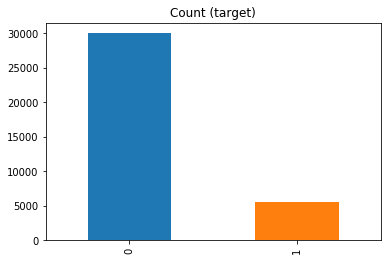

In [28]:
target_count = output.value_counts()
target_count.plot(kind='bar', title='Count (target)');


Class imbalance 85/15.
We try to balance this:

In [29]:
os_us = SMOTETomek(ratio='auto')
X_train_res, y_train_res = os_us.fit_sample(X_train, y_train)

In [30]:
print ("Distribution of class labels before resampling {Counter(y_train)}"
print ("Distribution of class labels after resampling {Counter(y_train_res)}")


Distribution of class labels before resampling Counter({0: 23996, 1: 4476})
Distribution of class labels after resampling Counter({0: 21823, 1: 21823})


In [31]:
gnb = GaussianNB()
y_pred = gnb.fit(X_train_res, y_train_res).predict(X_test)


In [32]:
print (classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.89      0.89      0.89      6010
          1       0.40      0.40      0.40      1109

avg / total       0.81      0.81      0.81      7119



 ### Predicting the attendance

In [42]:
input_data = sorted_df[['Age Category', 'Sex', 'Rank', 'Time', 'Year','run_count', 'years_since_run', 'particip_next_y']]
input_data_pred = input_data[input_data.Year==2016]             
X_topred = input_data_pred.drop(columns = ['particip_next_y'])
y_topred = input_data_pred['particip_next_y']